In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))                         # labels的维度:(n_train+n_test,)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))        #np.power()用于数组元素求n次方
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)  #向量进行点积
labels += np.random.normal(scale=0.1, size=labels.shape)    #添加标准差（方差）为0.1的正态分布噪音

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
# NumPy ndarray转换为tensor

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.8606],
         [-1.9371]]),
 tensor([[ 1.0000e+00, -1.8606e+00,  1.7309e+00, -1.0735e+00,  4.9935e-01,
          -1.8582e-01,  5.7623e-02, -1.5316e-02,  3.5622e-03, -7.3643e-04,
           1.3702e-04, -2.3177e-05,  3.5936e-06, -5.1432e-07,  6.8354e-08,
          -8.4787e-09,  9.8597e-10, -1.0791e-10,  1.1155e-11, -1.0923e-12],
         [ 1.0000e+00, -1.9371e+00,  1.8761e+00, -1.2114e+00,  5.8663e-01,
          -2.2727e-01,  7.3372e-02, -2.0304e-02,  4.9162e-03, -1.0581e-03,
           2.0496e-04, -3.6093e-05,  5.8263e-06, -8.6814e-07,  1.2012e-07,
          -1.5512e-08,  1.8780e-09, -2.1398e-10,  2.3028e-11, -2.3477e-12]]),
 tensor([ -8.8519, -10.5082]))

### 对模型进行训练和测试

首先让我们[**实现一个函数来评估模型在给定数据集上的损失**]。

In [5]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)         # Accumulator(n)首先会 self.data = [0.0] * n
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())  # 损失的总和,样本数量
    return metric[0] / metric[1]

# 定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]

    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])

    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                                batch_size, is_train=False)                     # huffle=is_train 

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0058417  1.204299  -3.389414   5.6079173]]


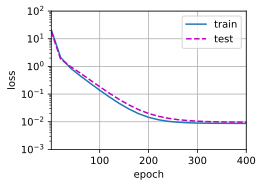

In [7]:
# 三阶多项式正常拟合
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.474445  3.4946532]]


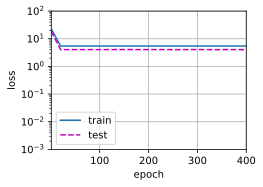

In [8]:
# 多项式欠拟合
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9906187   1.2758092  -3.2824543   5.1773767  -0.39785954  1.4929019
   0.09917084  0.07620025  0.22851996 -0.20543234 -0.13901336 -0.08575729
   0.02441137  0.04834175  0.04486471 -0.08769613  0.18844445  0.04972503
   0.13736627  0.21192414]]


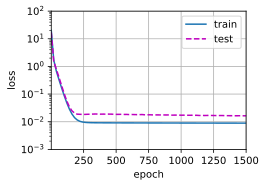

In [9]:
# 高阶多项式函数拟合(过拟合)
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)